##Heating Data Profile Extraction for HPZ Building

This notebook will extract typical profiles from the HPZ Heating meter for use as input for the coupled co-simulation with CitySim

In [1]:
import pandas as pd
import os
import seaborn

In [2]:
%matplotlib inline 

In [10]:
workingdir = "/Users/millerc/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"

In [11]:
os.chdir(workingdir)

In [14]:
df_PW = pd.read_csv("./aggset2_PW/HPZ_PW.csv", index_col="Date Time", parse_dates=True)

In [15]:
df_PW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70201 entries, 2006-07-01 00:00:00 to 2014-10-01 00:00:00
Data columns (total 8 columns):
HPZMHE01PW_A [kW]    66369 non-null float64
HPZMKA01PW_A [kW]    70169 non-null float64
HPZMEL50PW_A [kW]    18320 non-null float64
HPZMEL51PW_A [kW]    6616 non-null float64
HPZMEL52PW_A [kW]    18306 non-null float64
HPZMEL53PW_A [kW]    6106 non-null float64
HPZMHE96PW_A [kW]    6614 non-null float64
HPZMKA96PW_A [kW]    6613 non-null float64
dtypes: float64(8)
memory usage: 4.8 MB


In [16]:
df_heat = pd.DataFrame(df_PW["HPZMHE01PW_A [kW]"].truncate(before='2013',after='2014'))

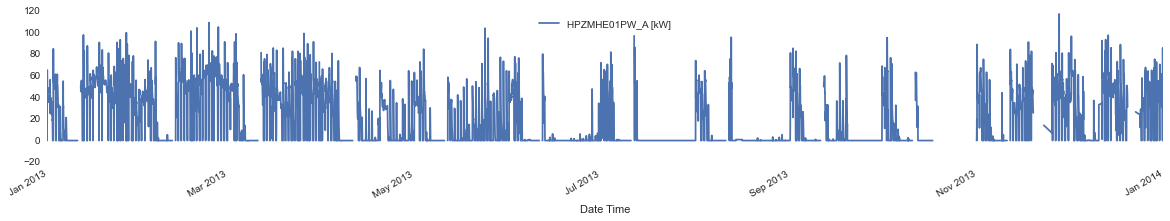

In [9]:
df_heat.plot(figsize=(20,3));

In [17]:
df_QW = pd.read_csv("./aggset2_QW/HPZ_QW.csv", index_col="Date Time", parse_dates=True)

In [22]:
df_QW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70201 entries, 2006-01-07 00:00:00 to 2014-01-10 00:00:00
Data columns (total 11 columns):
HPZMEL01QW_A [kWh]    54340 non-null float64
HPZMEL50QW_A [kWh]    18320 non-null float64
HPZMEL51QW_A [kWh]    11936 non-null float64
HPZMEL52QW_A [kWh]    18320 non-null float64
HPZMEL53QW_A [kWh]    6106 non-null float64
HPZMEL98QW_A [kWh]    54340 non-null float64
HPZMEL99QW_A [kWh]    54340 non-null float64
HPZMHE01QW_A [kWh]    67059 non-null float64
HPZMHE96QW_A [kWh]    10464 non-null float64
HPZMKA01QW_A [kWh]    70169 non-null float64
HPZMKA96QW_A [kWh]    10464 non-null float64
dtypes: float64(11)
memory usage: 6.4 MB


In [19]:
df_heat_QW = pd.DataFrame(df_QW["HPZMHE01QW_A [kWh]"].truncate(before='2013',after='2014'))

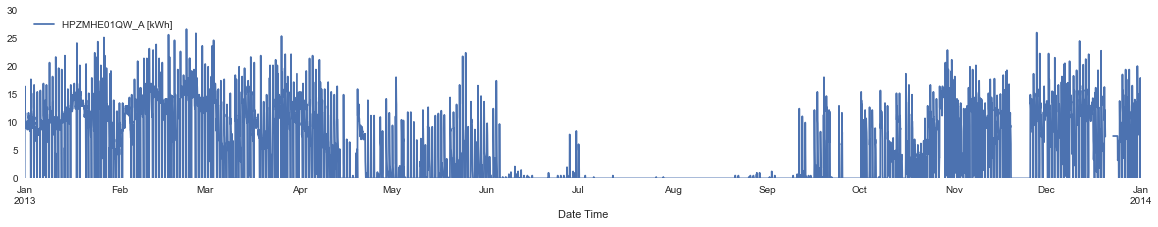

In [20]:
df_heat_QW.plot(figsize=(20,3));

##Pivot

##Convert to SAX

In [56]:
df = df_heat_QW.dropna()

In [57]:
df.head()

,HPZMHE01QW_A [kWh]
Date Time,
2013-01-01 00:00:00,0.00
2013-01-01 01:00:00,16.50
2013-01-01 02:00:00,11.00
2013-01-01 03:00:00,12.25
2013-01-01 04:00:00,11.25


In [58]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [59]:
df_pivot = pd.pivot_table(df, values='HPZMHE01QW_A [kWh]', index='Date', columns='Time')

In [43]:
a = 3
w = '4h'

In [44]:
from scipy.stats import norm
import numpy as np
import string

In [45]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [46]:
df_forSAX = df["HPZMHE01QW_A [kWh]"]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

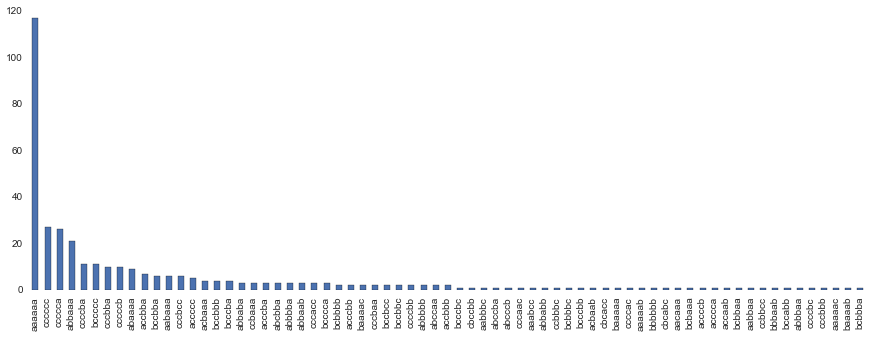

In [48]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [53]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

aaaaaa    117
cccccc     27
ccccca     26
abbaaa     21
ccccba     11
bccccc     11
cccbba     10
cccccb     10
abaaaa      9
dtype: int64

In [54]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords

accbba    7
bccbba    6
aabaaa    6
cccbcc    6
accccc    5
acbaaa    4
bccbbb    4
bcccba    4
abbaba    3
ccbaaa    3
acccba    3
abcbba    3
abbbba    3
abbaab    3
cccacc    3
bcccca    3
bcbbbb    2
acccbb    2
baaaac    2
cccbaa    2
bccbcc    2
bccbbc    2
ccccbb    2
abbbbb    2
abccaa    2
accbbb    2
bcccbc    1
cbccbb    1
aabbbc    1
abccba    1
abcccb    1
cccaac    1
aaabcc    1
abbabb    1
ccbbbc    1
bcbbbc    1
bcccbb    1
acbaab    1
cbcacc    1
baaaaa    1
ccccac    1
aaaaab    1
bbbbbb    1
cbcabc    1
aacaaa    1
bcbaaa    1
accccb    1
acccca    1
accaab    1
bcbbaa    1
aabbaa    1
ccbbcc    1
bbbaab    1
bccabb    1
abbbaa    1
ccccbc    1
cccbbb    1
aaaaac    1
baaaab    1
bcbbba    1
dtype: int64

In [86]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [87]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

#Cluster!

In [106]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [107]:
df = motifdata.drop(['SAXstring'], axis=1)

In [108]:
df.head()

,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,16.50,11,12.25,11.25,11.75,10.25,10.25,10.25,10.25,...,9.25,9.00,9.00,9.25,9.50,9.25,9.25,8.75,9.25,10.00
2013-01-02,10.25,9.50,10,9.50,10.50,11.25,11.75,10.75,11.25,11.00,...,9.50,8.75,8.50,10.25,10.00,10.00,10.75,11.25,11.25,2.75
2013-01-03,0.00,17.75,12,12.50,12.75,15.25,12.00,12.00,11.75,11.50,...,9.75,9.00,9.75,9.50,9.25,9.75,10.25,9.75,9.75,2.25
2013-01-05,0.00,0.00,0,15.50,8.75,8.50,8.50,8.00,8.25,8.75,...,7.75,8.75,8.25,8.50,8.75,8.75,8.50,8.75,8.50,9.00
2013-01-06,2.50,0.00,0,15.75,10.00,9.25,9.25,9.25,10.00,10.50,...,9.25,9.75,10.00,9.50,9.75,9.75,9.50,9.50,10.00,10.25


In [109]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [110]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.level_1)
df.index = df.timestampstring
df = df.drop(['Date','level_1','timestampstring'],axis=1)
df.columns = ["HPZ_Heating"]
df = df.resample('H')

In [111]:
df.head()

,HPZ_Heating
timestampstring,
2013-01-01 00:00:00,0.00
2013-01-01 01:00:00,16.50
2013-01-01 02:00:00,11.00
2013-01-01 03:00:00,12.25
2013-01-01 04:00:00,11.25


In [112]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [113]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [114]:
dailyblocks = pd.pivot_table(df, values='HPZ_Heating', index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values='HPZ_Heating', index='Date', columns='Time', aggfunc='mean')

In [129]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 5, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [130]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [131]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 


In [132]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [133]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

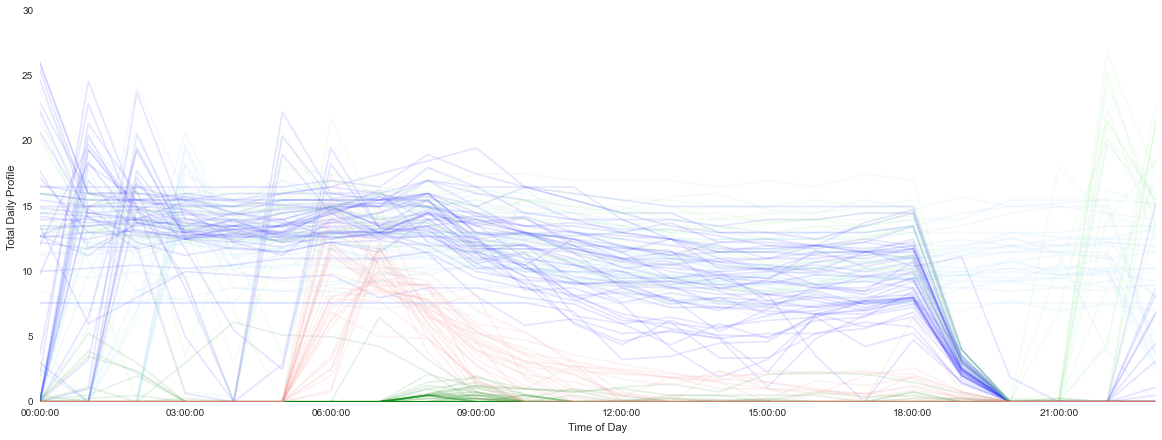

In [134]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 20, 7

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 10800))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("./graphics/clusters_total_overlaid_profiles.png")

In [135]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.level_2)
    df = df.dropna()
    return df

In [136]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

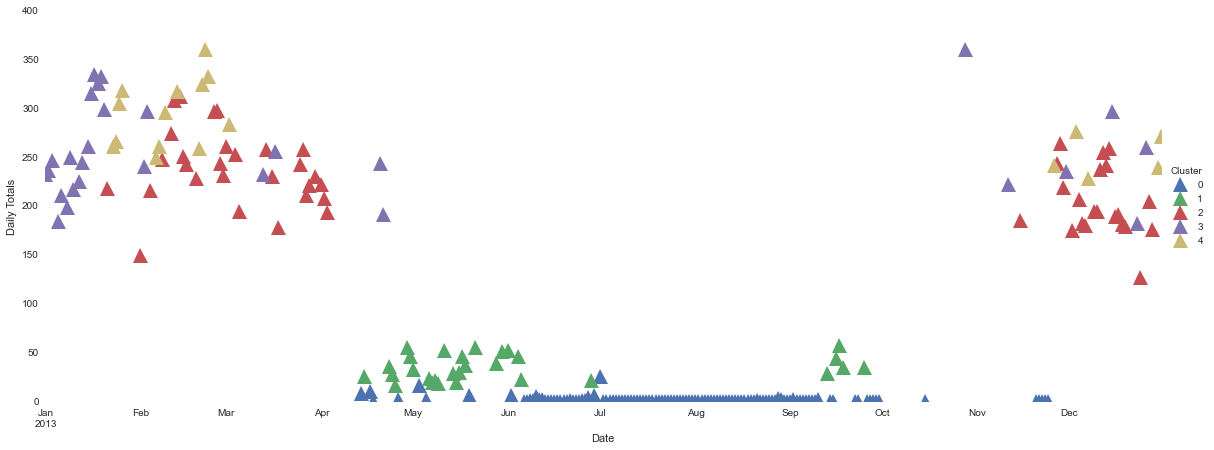

In [142]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=15)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("./graphics/clusters_overtime.png")

In [158]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2,0,1,2,3,4
timestampstring,,,,,
2013-01-01,NaN,NaN,NaN,232.75,NaN
2013-01-02,NaN,NaN,NaN,237.25,NaN
2013-01-03,NaN,NaN,NaN,246.75,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN
2013-01-05,NaN,NaN,NaN,185.25,NaN


In [159]:
calendar.to_csv("calendar.csv")

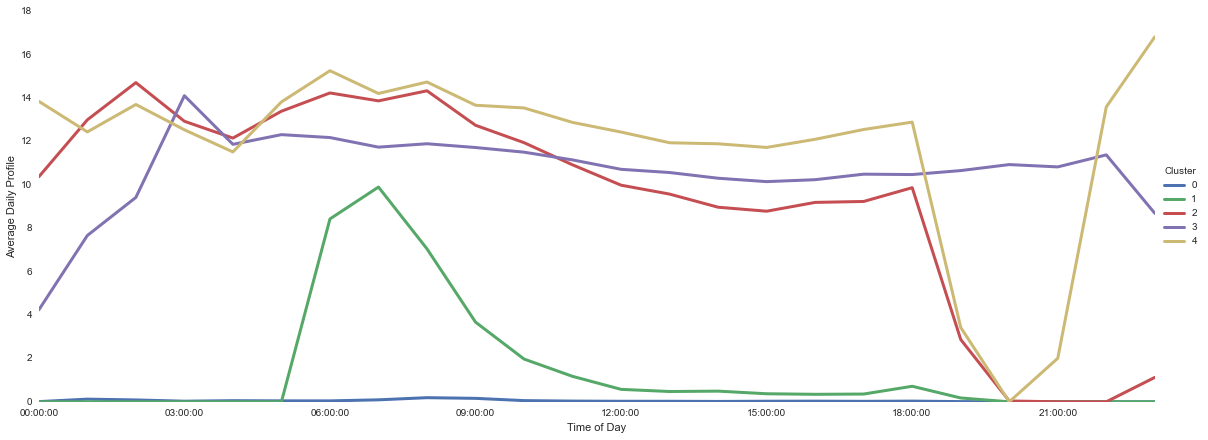

In [141]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(20,7),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("./graphics/clusters_averagedprofiles.png")

In [148]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / dfclusterunstackedpivoted.groupby('Time').max()

In [150]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles

ClusterNo2,0,1,2,3,4
Time,,,,,
00:00:00,0.016949,0.000000,0.396910,0.190361,0.576968
01:00:00,0.023406,0.000000,0.527687,0.378474,0.777344
02:00:00,0.028602,0.000000,0.619308,0.388395,0.702635
03:00:00,0.009181,0.000000,0.783509,0.679810,0.716270
04:00:00,0.008475,0.000000,0.736578,0.719091,0.719618
05:00:00,0.008475,0.000000,0.601833,0.724201,0.670034
06:00:00,0.008475,0.481527,0.729878,0.761093,0.701469
07:00:00,0.014016,0.659770,0.792447,0.722187,0.861111
08:00:00,0.058344,0.713662,0.754322,0.755034,0.818673


In [156]:
normalizedprofiles.to_csv("Schedules.csv")

In [139]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

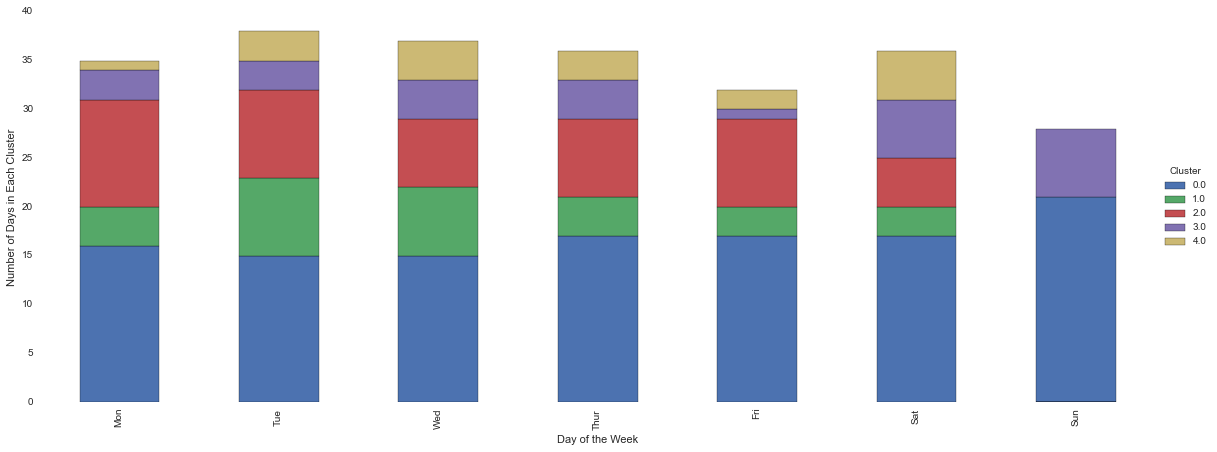

In [140]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsClusterplot1 = DayVsCluster.plot(figsize=(20,7),kind='bar',stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("./graphics/clusters_dailybreakdown.png")